In [1]:
#!pip install waymo-open-dataset-tf-2-11-0==1.6.0

import os
import jax
from jax import random
from jax import numpy as jnp
import tensorflow as tf
import tarfile
import mediapy

from waymo_open_dataset.protos import sim_agents_submission_pb2
from waymax import agents
from waymax import config as _config
from waymax import dynamics
from waymax import dataloader
from waymax import datatypes
from waymax import env as _env
from waymax import visualization

2024-04-17 09:39:45.264410: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-17 09:39:45.592710: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-17 09:39:45.592735: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-04-17 09:39:45.592739: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper

> ### Task description (TODO)

Goal: Generate realistic trajectories. Trajectories are `(x, y, z, heading)` tuples for every agent in the scene. 

> ### Open questions
- 1. What is the maximum number of objects in the scene we need to control? --> Current assumption: _All?_
- 2. What is the information (obs) can we use to train our policy?
- 3.


In [24]:
"""Global settings"""

# Index of the `current` step (11th when 1-indexed).
CURRENT_TIME_INDEX = 10
# Number of steps of simulation for a valid submission, the same length as
# the future states in the original scenario.
N_SIMULATION_STEPS = 80
# Number of steps expected for a training/validation Scenario and for a complete
# simulation (history + closed-loop simulation).
N_FULL_SCENARIO_STEPS = 91
# Number of parallel rollouts required for a valid submission.
N_ROLLOUTS = 1 # NOTE: Set to 32 for final submission.
# Duration (in seconds) of each step of simulation. This corresponds to the
# 10Hz frequency of the original Scenarios.
STEP_DURATION_SECONDS = 0.1

### 1. **Dataset** | Configure dataset and define iterator

To load data for a WOSAC submission, we write a custom dataloader that processes the scenario IDs. These are normally discarded in the default Waymax dataloader as they are not used during simulation and JAX does not have native support for string data. The scenario ID is stored in the field scenario/id as described in the tf.Example spec.

This custom dataloader defines a preprocessor _preprocess that decodes the scenario ID into an array of bytes, and a postprocessor _postprocess that converts those bytes into the string scenario ID. The actual scenario data is processed in the same way as the default dataloader in Waymax.

In [5]:
data_config = _config.WOD_1_2_0_TEST

data_config # Inspect the configurations

DatasetConfig(path='gs://waymo_open_dataset_motion_v_1_2_0/uncompressed/tf_example/testing/testing_tfexample.tfrecord@150', data_format=<DataFormat.TFRECORD: 'TFRECORD'>, repeat=None, batch_dims=(), shuffle_seed=None, shuffle_buffer_size=1000, num_shards=4, deterministic=True, include_sdc_paths=False, aggregate_timesteps=True, max_num_rg_points=30000, max_num_objects=None, num_paths=None, num_points_per_path=None, drop_remainder=True, tf_data_service_address=None, distributed=False, batch_by_scenario=True)

In [6]:
# Write a custom dataloader that loads scenario IDs.
def _preprocess(serialized: bytes) -> dict[str, tf.Tensor]:
  womd_features = dataloader.womd_utils.get_features_description(
      include_sdc_paths=data_config.include_sdc_paths,
      max_num_rg_points=data_config.max_num_rg_points,
      num_paths=data_config.num_paths,
      num_points_per_path=data_config.num_points_per_path,
  )
  womd_features['scenario/id'] = tf.io.FixedLenFeature([1], tf.string)

  deserialized = tf.io.parse_example(serialized, womd_features)
  parsed_id = deserialized.pop('scenario/id')
  deserialized['scenario/id'] = tf.io.decode_raw(parsed_id, tf.uint8)

  return dataloader.preprocess_womd_example(
      deserialized,
      aggregate_timesteps=data_config.aggregate_timesteps,
      max_num_objects=data_config.max_num_objects,
  )

def _postprocess(example: dict[str, tf.Tensor]):
  scenario = dataloader.simulator_state_from_womd_dict(example)
  scenario_id = example['scenario/id']
  return scenario_id, scenario

def decode_bytes(data_iter):
  for scenario_id, scenario in data_iter:
    scenario_id = scenario_id.tobytes().decode('utf-8')
    yield scenario_id, scenario

In [7]:
# Define the data iterator.
data_iter = decode_bytes(dataloader.get_data_generator(
      data_config, _preprocess, _postprocess
))

In [8]:
# Obtain a scenario
scenario_id, scenario = next(data_iter)

2024-04-17 09:40:37.764129: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-17 09:40:37.764161: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-04-17 09:40:37.764176: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-04-17 09:40:37.764191: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2024-04-17 09:40:37.780524: W tensorfl

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


### 2. **Make environment**

In [9]:
env_config = _config.EnvironmentConfig(
    # Ensure that the sim agent can control all valid objects. 
    controlled_object=_config.ObjectType.VALID
)

dynamics_model = dynamics.InvertibleBicycleModel()
env = _env.MultiAgentEnvironment(
    dynamics_model=dynamics_model,
    config=env_config,
)

#TODO: Our policy goes here
agent = agents.create_constant_speed_actor(
    dynamics_model=dynamics_model,
    # Controlled objects are those valid at t=0.
    is_controlled_func=lambda state: state.log_trajectory.valid[..., CURRENT_TIME_INDEX]
)

# Jit step & select_action functions
jit_step = jax.jit(env.step)
jit_select_action = jax.jit(agent.select_action)

### What to simulate?

Vehicles are represented as bounding boxes, and we are interested in how they move around the world. Our task is to simulate the following fields in `sim_agents_submission_pb2.SimulatedTrajectory`:

- 3D coordinates of the boxes centers (x/y/z, same reference frame as the original Scenario).
- Heading of those objects (again, same definition as the original Scenario proto).

All the objects that are valid at the last step of the initial state (i.e. the 11th when 1-indexed, the last observable one in the test set data) needs to be resimulated. We provide a simple util function (shown below) to identify who needs to be resimulated.

We show how these inputs can be accessed below:

In [10]:
# Seed
key = random.PRNGKey(0)

# Intialize environment
current_state = env.reset(scenario)

# Controlled objects are those valid at t=0.
is_controlled = scenario.log_trajectory.valid[..., CURRENT_TIME_INDEX]

type(current_state)

waymax.datatypes.simulator_state.SimulatorState

In [11]:
#dir(current_state)

In [12]:
current_state.remaining_timesteps

Array(80, dtype=int32)

### ✏️ **Important note**:
- `state.log_trajectory` contains the _recorded_ human driver logs
- `state.sim_trajectory` contains the actual, _realized_ logs with the specified actors


In [18]:
for time_step in (range(80)):
    
    key, actor_key = random.split(key, 2)
    
    # TODO: OUR POLICY GOES HERE
    actor_output = jit_select_action({}, current_state, None, actor_key)
    
    # Step
    next_state = jit_step(current_state, actor_output.action)
    current_state = next_state
    
# Write out result
final_trajectory = current_state.sim_trajectory
object_ids = current_state.object_metadata.ids  # Shape (n_objects,)
object_ids = jnp.where(is_controlled, object_ids, -1);

### What information in `SimulatorState` can we use during training and how should we use it?

- the `roadgraph_points`
- the `log_traffic_light`
- the `sim_trajectory`
- the `log_trajectory`

In [14]:
current_state.roadgraph_points.shape

(30000,)

In [15]:
current_state.roadgraph_points

RoadgraphPoints(x=Array([ 8.510950e+03,  8.510970e+03,  8.510987e+03, ..., -1.000000e+00,
       -1.000000e+00, -1.000000e+00], dtype=float32), y=Array([ 6.0185850e+03,  6.0195674e+03,  6.0205503e+03, ...,
       -1.0000000e+00, -1.0000000e+00, -1.0000000e+00], dtype=float32), z=Array([-22.565464, -22.568071, -22.57068 , ...,  -1.      ,  -1.      ,
        -1.      ], dtype=float32), dir_x=Array([ 0.01911646,  0.01861238,  0.0181083 , ..., -1.        ,
       -1.        , -1.        ], dtype=float32), dir_y=Array([ 0.99981374,  0.9998233 ,  0.9998325 , ..., -1.        ,
       -1.        , -1.        ], dtype=float32), dir_z=Array([-0.00265407, -0.00265407, -0.00265407, ..., -1.        ,
       -1.        , -1.        ], dtype=float32), types=Array([ 2,  2,  2, ..., -1, -1, -1], dtype=int32), ids=Array([166, 166, 166, ...,  -1,  -1,  -1], dtype=int32), valid=Array([ True,  True,  True, ..., False, False, False], dtype=bool))

In [20]:
current_state.sim_trajectory.shape

(128, 91)

In [16]:
current_state.log_traffic_light.shape

(16, 91)

In [187]:
#dir(current_state.sim_trajectory)

In [188]:
final_trajectory.shape # Number of objects in the scene, number of timesteps

(128, 91)

### Visualize scenario at timestep $t$

""

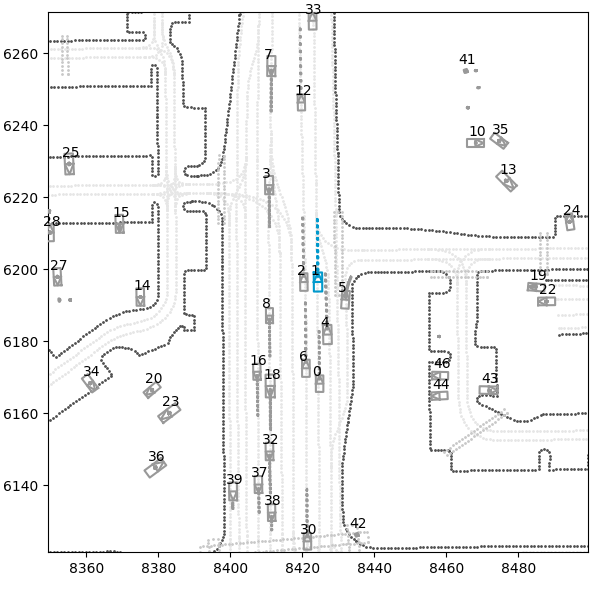

In [17]:
# Using logged trajectory
img = visualization.plot_simulator_state(scenario, use_log_traj=True)
mediapy.show_image(img)

### Evaluate policy

In [25]:
joint_scenes = []
key = random.PRNGKey(0)
for _ in range(N_ROLLOUTS):
    initial_state = current_state = env.reset(scenario)
    # Controlled objects are those valid at t=0.
    is_controlled = scenario.log_trajectory.valid[..., CURRENT_TIME_INDEX]

    # Run the sim agent for 80 steps.
    for _ in (range(initial_state.remaining_timesteps)):
        key, actor_key = random.split(key, 2)
        actor_output = jit_select_action({}, current_state, None, actor_key)
        next_state = jit_step(current_state, actor_output.action)
        current_state = next_state

    # Write out result
    final_trajectory = current_state.sim_trajectory
    object_ids = current_state.object_metadata.ids  # Shape (n_objects,)
    object_ids = jnp.where(is_controlled, object_ids, -1)

    simulated_trajectories = []
    for i, object_id in enumerate(object_ids):
        if object_id != -1:
            simulated_trajectory = sim_agents_submission_pb2.SimulatedTrajectory(
                    center_x=final_trajectory.x[i, env_config.init_steps:],
                    center_y=final_trajectory.y[i, env_config.init_steps:],
                    center_z=final_trajectory.z[i, env_config.init_steps:],
                    heading=final_trajectory.yaw[i, env_config.init_steps:],
                    object_id=object_id,
            )
            simulated_trajectories.append(simulated_trajectory)
    
    # Create a joint scene object
    joint_scene = sim_agents_submission_pb2.JointScene(
            simulated_trajectories=simulated_trajectories
    )
    joint_scenes.append(joint_scene)

# scenario_rollouts =  sim_agents_submission_pb2.ScenarioRollouts(
#     scenario_id=scenario_id, joint_scenes=joint_scenes
# )

In [29]:
simulated_trajectories

[center_x: 8424.693359375
 center_x: 8424.6923828125
 center_x: 8424.69140625
 center_x: 8424.6904296875
 center_x: 8424.689453125
 center_x: 8424.6884765625
 center_x: 8424.6875
 center_x: 8424.6865234375
 center_x: 8424.685546875
 center_x: 8424.6845703125
 center_x: 8424.68359375
 center_x: 8424.6826171875
 center_x: 8424.681640625
 center_x: 8424.6806640625
 center_x: 8424.6796875
 center_x: 8424.6787109375
 center_x: 8424.677734375
 center_x: 8424.6767578125
 center_x: 8424.67578125
 center_x: 8424.6748046875
 center_x: 8424.673828125
 center_x: 8424.6728515625
 center_x: 8424.671875
 center_x: 8424.6708984375
 center_x: 8424.669921875
 center_x: 8424.6689453125
 center_x: 8424.66796875
 center_x: 8424.6669921875
 center_x: 8424.666015625
 center_x: 8424.6650390625
 center_x: 8424.6640625
 center_x: 8424.6630859375
 center_x: 8424.662109375
 center_x: 8424.6611328125
 center_x: 8424.66015625
 center_x: 8424.6591796875
 center_x: 8424.658203125
 center_x: 8424.6572265625
 center_x:

In [30]:
from waymax import metrics